# Weather Temperature Predictions - OLS Regression

A **multiple linear regression model** is a statistical method that describes the linear relationship between a continuous target (Dependent/ Y variable) and two or more features (Independent/ X variables), determining how much each features contributes to the outcome. 

---

### Define the Problem
Can Temperature be accurately predicted knowing the Dew Point Temperature, Relative Humidity %, Wind Speed km/h, Visibility km, and/ or Pressure kPa?


**The dataset** aims to predict the Temperature based on the Dew Point Temperature, Relative Humidity %, Wind Speed km/h, Visibility km, and/ or Pressure kPa. This dataset is found on kaggle - https://www.kaggle.com/code/esraameslamsayed/eda-for-weather-dataset-for-beginners/log? It does not state any descriptive factors about where this data is from or when it was captured. The only descriptive feature is that Temperature and Dew Point Temperature is measured in degrees celsius.

**Features:**
- Dew Point Temp_C
- Rel Hum_%
- Wind Speed_km/h
- Visibility_km
- Press_kPa	

**Target:**
- Temperature

---

### Summary of Findings

This notebook builds an interpretable baseline for temperature (Temp_C) using OLS. I first drop non-numeric or non-predictive columns—Weather (categorical), Date/Time, Visibility_km—and trim the top 1% of Wind Speed_km/h to reduce outlier influence. An initial OLS with dew point, pressure, humidity, and wind yields R² ≈ 0.995; coefficients indicate a near 1-to-1 slope for dew point (≈ +1.056 °C per °C), humidity has a negative association (≈ −0.249 °C per %), pressure small negative (≈ −0.095 °C per kPa), and wind is not significant (p≈0.082). Diagnostic stats look sound: Durbin–Watson ≈ 2.00. However, VIF shows strong multicollinearity between pressure and humidity (≈16–17), so I remove pressure and proceed with dew point + humidity only; VIF then drops to ≈1.06. Features are standardized and the model is evaluated with an 80/20 train–test split using LinearRegression. Training performance remains R² ≈ 0.995, test residuals are centered near zero, and the median absolute percentage error ~5% (the mean is inflated by targets near 0°C). The result is a clean, explainable baseline that captures most variance with two physically sensible predictors.

---

### Import Libraries

Working in Python 3.9.12 and the Package versions are:
- pandas: 1.5.3
- numpy: 1.23.5
- statsmodels: 0.14.2
- matplotlib: 3.9.2
- seaborn: 0.13.2
- scikit-learn: 1.2.2

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# and of course the actual regression (machine learning) module
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings("ignore")

### Import Data

I took a random sample of 3000 values from the dataset as it was over 8000.

In [ ]:
raw_data = pd.read_csv('../data/weather_data.csv')

# Select a random sample of 3000 rows
# random_state for reproducibility
sample_data = raw_data.sample(n=3000, random_state=42)  
data = sample_data.copy()

### Load Data

In [3]:
data = data.reset_index(drop=True)
data.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,9/23/2012 1:00,12.8,9.6,81,17,25.0,100.46,Mostly Cloudy
1,3/3/2012 0:00,1.0,-3.2,73,22,25.0,100.12,Cloudy
2,9/29/2012 11:00,12.6,9.8,83,24,24.1,101.19,Cloudy
3,5/11/2012 9:00,11.7,1.6,50,19,48.3,100.63,Mainly Clear
4,1/21/2012 16:00,-11.6,-18.8,55,7,48.3,102.11,Clear


### Preprocessing
---

### Exploring the descriptive statistics of the variables

In [4]:
data.describe()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8.584600,2.260300,67.001667,15.299000,27.755300,101.060323
std,11.890596,11.108932,16.927685,8.872307,12.669205,0.845050
min,-21.100000,-26.800000,18.000000,0.000000,0.200000,97.640000
25%,-0.300000,-6.100000,56.000000,9.000000,24.100000,100.550000
50%,9.200000,2.700000,68.000000,15.000000,25.000000,101.090000
75%,18.700000,11.700000,81.000000,20.000000,25.000000,101.580000
max,33.000000,23.200000,100.000000,70.000000,48.300000,103.650000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date/Time         3000 non-null   object 
 1   Temp_C            3000 non-null   float64
 2   Dew Point Temp_C  3000 non-null   float64
 3   Rel Hum_%         3000 non-null   int64  
 4   Wind Speed_km/h   3000 non-null   int64  
 5   Visibility_km     3000 non-null   float64
 6   Press_kPa         3000 non-null   float64
 7   Weather           3000 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 187.6+ KB


## Regression Analysis
---

### Visuals | Histograms
Check for normal distribution of data

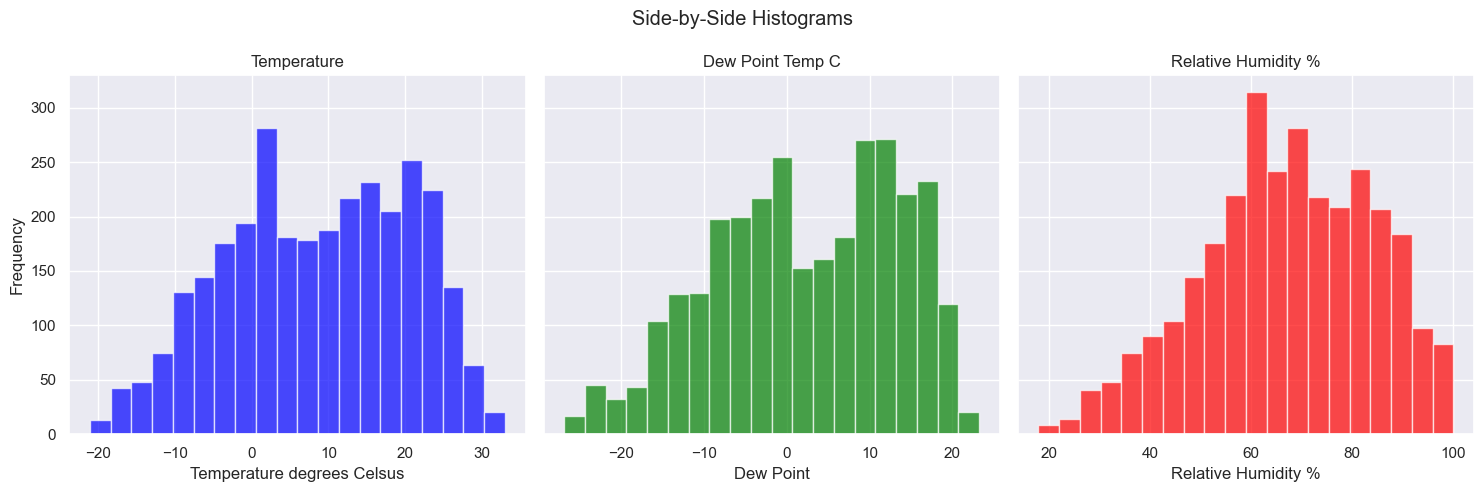

In [6]:
temperature = data['Temp_C']
dew_point = data['Dew Point Temp_C']
rel_humidity = data['Rel Hum_%']

# Create a 1x3 grid of subplots
# sharey=True to use the same y-axis scale
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  

# Plot each histogram on a separate subplot
axes[0].hist(temperature, bins = 20, color='blue', alpha=0.7)
axes[0].set_title('Temperature')
axes[0].set_xlabel('Temperature degrees Celsus')
axes[0].set_ylabel('Frequency')

axes[1].hist(dew_point, bins = 20, color='green', alpha=0.7)
axes[1].set_title('Dew Point Temp C')
axes[1].set_xlabel('Dew Point')

axes[2].hist(rel_humidity, bins = 20, color='red', alpha=0.7)
axes[2].set_title('Relative Humidity %')
axes[2].set_xlabel('Relative Humidity %')


# Add a main title
fig.suptitle('Side-by-Side Histograms')

# Display the plot
plt.tight_layout()
plt.show()

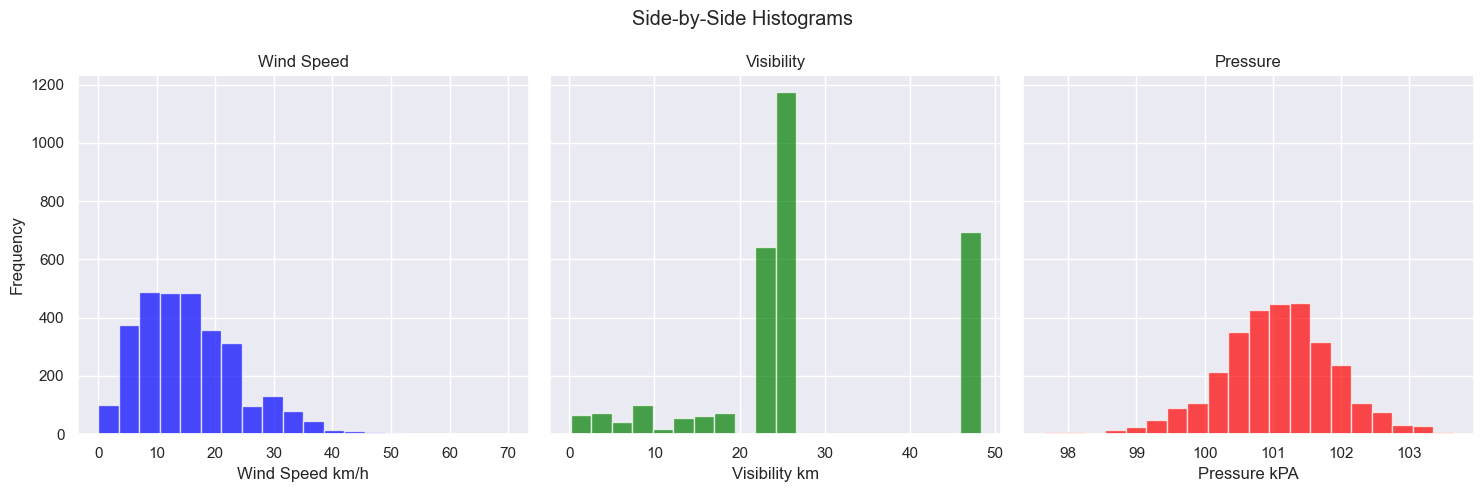

In [7]:
wind_speed = data['Wind Speed_km/h']
visibility = data['Visibility_km']
pressure = data['Press_kPa']

# Create a 1x3 grid of subplots
# sharey=True to use the same y-axis scale
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  

# Plot each histogram on a separate subplot
axes[0].hist(wind_speed, bins=20, color='blue', alpha=0.7)
axes[0].set_title('Wind Speed')
axes[0].set_xlabel('Wind Speed km/h')
axes[0].set_ylabel('Frequency')

axes[1].hist(visibility, bins=20, color='green', alpha=0.7)
axes[1].set_title('Visibility')
axes[1].set_xlabel('Visibility km')

axes[2].hist(pressure, bins=20, color='red', alpha=0.7)
axes[2].set_title('Pressure')
axes[2].set_xlabel('Pressure kPA')

# Add a main title
fig.suptitle('Side-by-Side Histograms')

# Display the plot
plt.tight_layout()
plt.show()

Most variables appear to be normally distributed except for Wind Speed and Visibility. It is likley to remove Visibility overall and then remove outliers from Wind Speed.

### Remove Visibility

In [8]:
# Dropping Visibility and other unnecessary columns 
normal_data = data.drop(['Visibility_km','Date/Time','Weather'],axis=1)

### Remove Outliers

In [9]:
# There are some outliers present with Wind Speed and outliers are an issue for OLS as it can skew the predictions
# OLS minimizes the sum of squared errors, so larger errors have a disproportionately high influence. 
# An outlier with a large residual will heavily impact the line of best fit, 
# often skewing the regression coefficients and thus leading to inaccurate estimates
# Here, the outliers are situated around Wind Speed (right side of the graph)
# Let's remove 1% of the problematic samples

# Declare q as a variable that will be equal to the 99th percentile of the 'Wind Speed_km/h' variable
# DataFrame.quantile(the quantile)
q = normal_data['Wind Speed_km/h'].quantile(0.99)
# Create a new df, with the condition that all Wind Speeds must be below the 99 percentile of 'Wind Speed_km/h'
data_1 = normal_data[normal_data['Wind Speed_km/h']<q]
# The top 1% of the data about 'Wind Speed_km/h' has been removed
data_1.describe(include='all')

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Press_kPa
count,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,8.630064,2.292315,66.957196,14.948433,101.077331
std,11.929052,11.148546,16.947238,8.247501,0.827982
min,-21.100000,-26.800000,18.000000,0.000000,97.640000
25%,-0.300000,-6.200000,56.000000,9.000000,100.570000
50%,9.300000,2.900000,68.000000,15.000000,101.090000
75%,18.800000,11.700000,81.000000,20.000000,101.590000
max,33.000000,23.200000,100.000000,39.000000,103.650000


<Axes: xlabel='Wind Speed_km/h', ylabel='Count'>

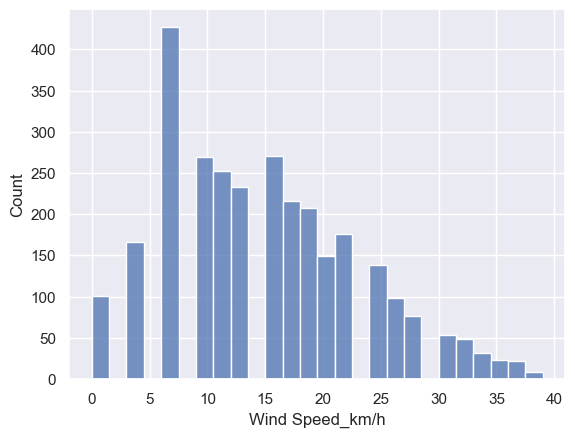

In [10]:
sns.histplot(data_1['Wind Speed_km/h'])

### Reset Index

In [11]:
# When removing observations, the original indexes are preserved so they need to be reset
# Once the index is reset a new column will be created containing the old index (just in case)
# This will not be necessary, thus 'drop=True' to completely forget about it
data_cleaned = data_1.reset_index(drop=True)

In [12]:
data_cleaned.describe(include='all')

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Press_kPa
count,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,8.630064,2.292315,66.957196,14.948433,101.077331
std,11.929052,11.148546,16.947238,8.247501,0.827982
min,-21.100000,-26.800000,18.000000,0.000000,97.640000
25%,-0.300000,-6.200000,56.000000,9.000000,100.570000
50%,9.300000,2.900000,68.000000,15.000000,101.090000
75%,18.800000,11.700000,81.000000,20.000000,101.590000
max,33.000000,23.200000,100.000000,39.000000,103.650000


## Check Assumptions

### 1. Linearity with Scatter Plot

### Temperature

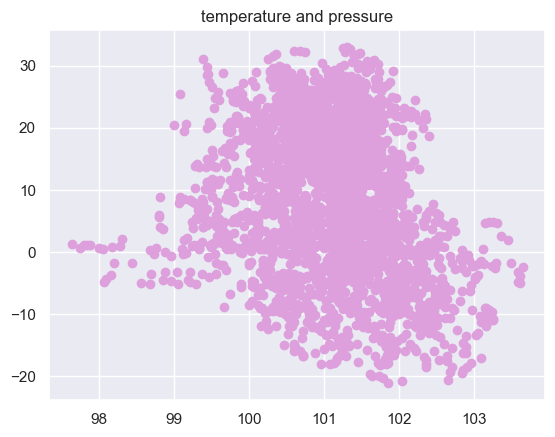

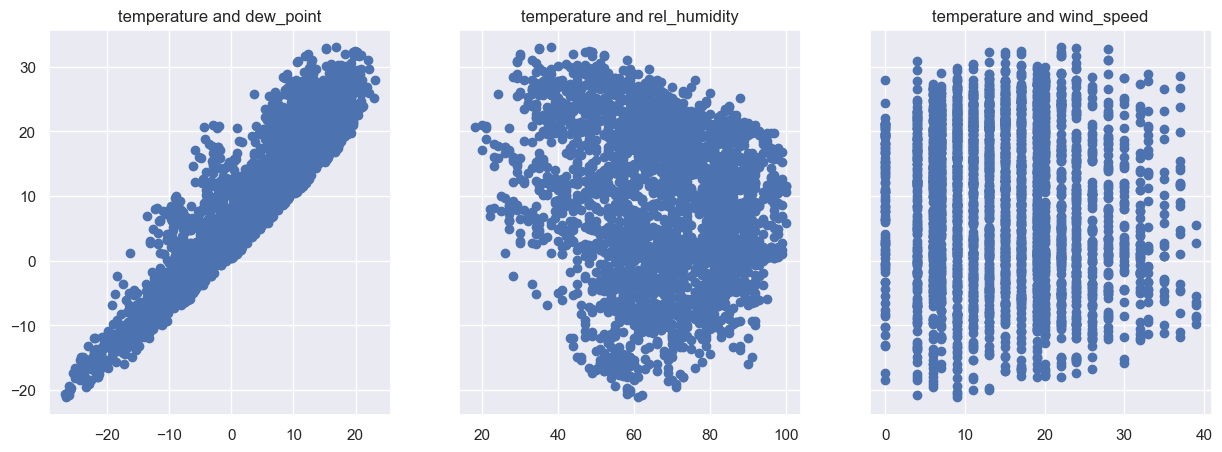

In [13]:
plt.scatter(data_cleaned['Press_kPa'], data_cleaned['Temp_C'], c = '#DDA0DD')
plt.title('temperature and pressure')


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,5)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Dew Point Temp_C'], data_cleaned['Temp_C'])
ax1.set_title('temperature and dew_point')
ax2.scatter(data_cleaned['Rel Hum_%'], data_cleaned['Temp_C'])
ax2.set_title('temperature and rel_humidity')
ax3.scatter(data_cleaned['Wind Speed_km/h'], data_cleaned['Temp_C'])
ax3.set_title('temperature and wind_speed')
plt.show()

Linearity - All scatter plots are linear except the Wind Speed scatter plot. It is non linear but lets run other tests first before it is removed.

### 2. Check for Endogeneity

Check variables to make sure their p value <= 0.05 - if it is larger then they need to be removed.

In [14]:
y = data_cleaned['Temp_C']
x1 = data_cleaned[['Dew Point Temp_C', 'Press_kPa','Rel Hum_%', 'Wind Speed_km/h']]
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Temp_C   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.485e+05
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        11:29:40   Log-Likelihood:                -3693.0
No. Observations:                2967   AIC:                             7396.
Df Residuals:                    2962   BIC:                             7426.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               32.5771      2.257     14.433      0.000      28.152      37.003
Dew Point Temp_C     1.0556      0.002    697.114      0.000       1.053       1.059
Press_kPa           -0.0950      0.022     -4.317      0.000      -0.138      -0.052
Rel Hum_%           -0.2495      0.001   -260.520      0.000      -0.251      -0.248
Wind Speed_km/h     -0.0036      0.002     -1.740      0.082      -0.008       0.000
==============================================================================
Omnibus:                     1378.604   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9342.758
Skew:                           2.100   Prob(JB):                         0.00
Kurtosis:                      10.611   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Wind Speed has a p-value of 0.082 so it must be dropped.

In [15]:
data_cleaned = data_cleaned.drop(['Wind Speed_km/h'],axis=1)

### 3. Normality and Homoscedasticity

- Normality - assume the error term is normally distributed
- Homoscedasticity - to have equal variance. The error term should have equal variance, one with the other. If there is heteroscedasticity (huge variance) the you can calculate the naturl log

The histograms appear normally distributed and the scatter plots show Homoscedasity in all variables except for Wind Speed and Visibility - which both variables have been removed from the dataset.

### 4. Check for Autocorrelation

- The correlation of a variable with itsself over successive time intervals 
- Use the Durbin Watson test - 0 - 4. 2 indicates no autocorrelation while values below 1 and above 3 cause for alarm use

In [16]:
# Data
y = data_cleaned['Temp_C']
x1 = data_cleaned[['Dew Point Temp_C', 'Rel Hum_%', 'Press_kPa']]

# Add a constant to the independent variables
x = sm.add_constant(x1)

# Fit the OLS regression model
model = sm.OLS(y, x).fit()

# Calculate the Durbin-Watson statistic on the residuals
dw_statistic = durbin_watson(model.resid)
print("Durbin-Watson Statistic:", dw_statistic)

Durbin-Watson Statistic: 2.003220218203236


- The Durbin-Watson statistic ranges from 0 to 4:

    - Results 2: Indicates no autocorrelation.
    - Results 0 to <2: Indicates positive autocorrelation.
    - Results >2 to 4: Indicates negative autocorrelation.

 The Results are 2.00 meaning there is no autocorrelation.

### 5. Check for Multicollinearity

Multicollinearity is observed when two or more variables have a high correlation.

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data_cleaned[['Dew Point Temp_C', 'Rel Hum_%','Press_kPa']]

# create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# include names so it is easier to explore the result
vif["Features"] = variables.columns

vif

,VIF,Features
0,1.069583,Dew Point Temp_C
1,16.795114,Rel Hum_%
2,16.543918,Press_kPa


- VIF = 1: no multicollinearity
- 1 < VIF < 5: perfectly okay
- 5 to 10 < VIF: unacceptable

Relative Humidity is the highest but after running the model it had a lower R Squared and a high % difference between Training and Testing Data predictions so Pressure is removed instead. This will drive the VIF of other variables down.

In [18]:
variables = data_cleaned[['Dew Point Temp_C', 'Rel Hum_%']]

# create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# include names so it is easier to explore the result
vif["Features"] = variables.columns

vif

,VIF,Features
0,1.056978,Dew Point Temp_C
1,1.056978,Rel Hum_%


All variables are now below 5.

In [19]:
# Drop all irrelevant columns
data_no_multicollinearity = data_cleaned.drop(['Press_kPa'],axis=1)
data_no_multicollinearity

,Temp_C,Dew Point Temp_C,Rel Hum_%
0,12.8,9.6,81
1,1.0,-3.2,73
2,12.6,9.8,83
3,11.7,1.6,50
4,-11.6,-18.8,55
...,...,...,...
2962,-4.6,-10.0,66
2963,-12.7,-20.4,53
2964,12.6,9.7,82
2965,17.3,8.9,58


## Regression Testing
---

In [20]:
# Give Data a new name
regression_data = data_no_multicollinearity
regression_data

,Temp_C,Dew Point Temp_C,Rel Hum_%
0,12.8,9.6,81
1,1.0,-3.2,73
2,12.6,9.8,83
3,11.7,1.6,50
4,-11.6,-18.8,55
...,...,...,...
2962,-4.6,-10.0,66
2963,-12.7,-20.4,53
2964,12.6,9.7,82
2965,17.3,8.9,58


### Declare the inputs and the targets

In [21]:
# The target(s) (y - dependent variable) is 'Temp_C'
targets = regression_data['Temp_C']

# The inputs are everything BUT the y - dependent variable
inputs = regression_data.drop(['Temp_C'],axis=1)

### Scale & Transform the data

As the different input variables have different measurements - Realative Humidity is a percentage and Dew Point Temperature is in degrees celsius, they will be scaled.

In [22]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler()

In [23]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [24]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
# first argument refers to the x's & second argument refers to the y's
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

### Create the Regression

In [25]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression()

In [27]:
# Create a variable to store the predictions based on the training data
y_hat = reg.predict(x_train)

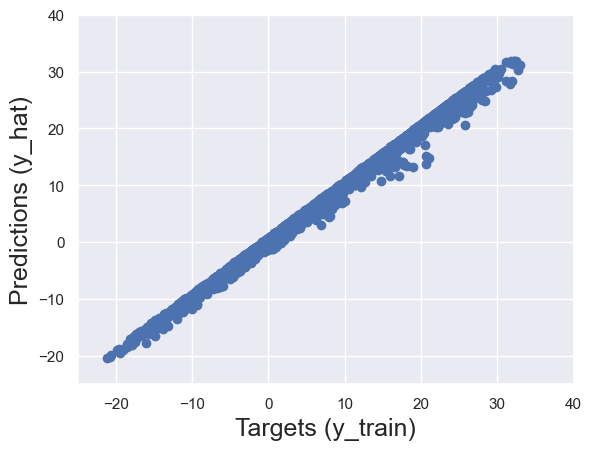

In [28]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)

# Making the y-axis to be the same as to interpret the '45-degree line'
plt.xlim(-25,40)
plt.ylim(-25,40)
plt.show()

### Plot the Residuals

Text(0.5, 1.0, 'Residuals PDF')

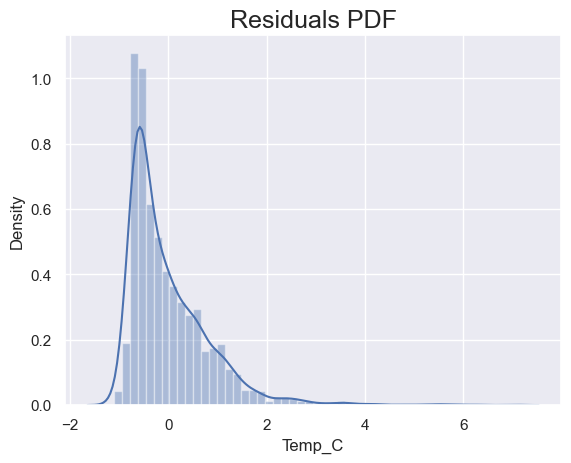

In [29]:
# Plot the PDF of the residuals and check for anomalies
sns.distplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

For the best case scenario this plot should be normally distributed. With this dataset there are many positive residuals - far away from the mean.

### Find the R Squared

In [30]:
reg.score(x_train,y_train)

0.9950888806733126

### Finding the weights and bias (intercept)

In [31]:
reg.intercept_

8.615900934304305

In [32]:
# Obtain the weights (coefficients) of the regression
reg.coef_

array([11.78175877, -4.20691443])

In [33]:
# Create a regression summary
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
intercept_row = pd.DataFrame([['Intercept', reg.intercept_]], columns=['Features', 'Weights'])
reg_summary = pd.concat([intercept_row, reg_summary], ignore_index=True)
reg_summary

,Features,Weights
0,Intercept,8.615901
1,Dew Point Temp_C,11.781759
2,Rel Hum_%,-4.206914


### Temperature Regression

In [34]:
x = sm.add_constant(x_train)
results = sm.OLS(y_train,x).fit()
#.fit() applys estimation technique (OLS - ordinary least square) to obtain the fit of the model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Temp_C   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.401e+05
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        11:32:30   Log-Likelihood:                -2940.0
No. Observations:                2373   AIC:                             5886.
Df Residuals:                    2370   BIC:                             5903.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6159      0.017    502.149      0.000       8.582       8.650
x1            11.7818      0.017    679.817      0.000      11.748      11.816
x2            -4.2069      0.018   -240.171      0.000      -4.241      -4.173
==============================================================================
Omnibus:                     1173.912   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9114.498
Skew:                           2.204   Prob(JB):                         0.00
Kurtosis:                      11.529   Cond. No.                         1.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Testing

The model has been trained and fine-tuned and it is time to proceed to testing it. 
Testing is done on a dataset that the algorithm has never seen.

In [35]:
# The test inputs are 'x_test', while the outputs: 'y_test' 
y_hat_test = reg.predict(x_test)

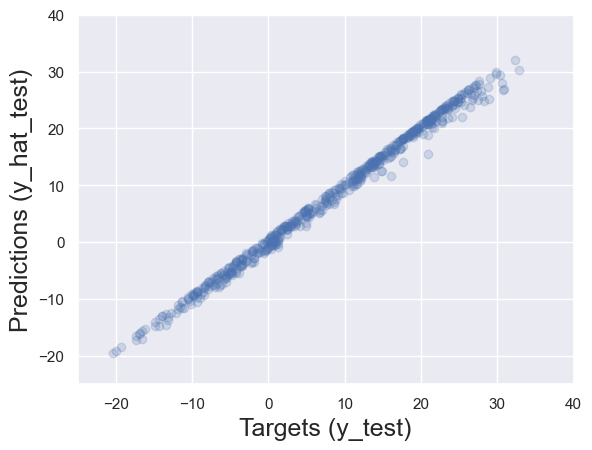

In [36]:
# Create a scatter plot with the test targets and the test predictions
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(-25,40)
plt.ylim(-25,40)
plt.show()

The model appears to be great at predicting lower to average temperatures but shows dispersion around higher temperatures.

In [37]:
# Create a DataFrame to manually check the predictions
df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pf.head()

,Prediction
0,12.551189
1,22.275368
2,-0.307035
3,11.791994
4,11.725409


In [38]:
# Reset the index as the old indexes are preserved 
y_test = y_test.reset_index(drop=True)

# Check the result
y_test.head()

0    12.0
1    21.7
2    -0.6
3    12.0
4    11.0
Name: Temp_C, dtype: float64

In [39]:
# Add a 'Target' column with the appropriate values
df_pf['Target'] = y_test
df_pf.head(10)

,Prediction,Target
0,12.551189,12.0
1,22.275368,21.7
2,-0.307035,-0.6
3,11.791994,12.0
4,11.725409,11.0
5,-6.951132,-7.5
6,18.839081,18.2
7,-7.155347,-6.8
8,-1.344209,-2.0
9,-10.989672,-11.9


In [40]:
# Manually create the Residuals
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [41]:
# Manually create the absolute difference in %
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.head(15)

,Prediction,Target,Residual,Difference%
0,12.551189,12.0,-0.551189,4.593241
1,22.275368,21.7,-0.575368,2.651463
2,-0.307035,-0.6,-0.292965,48.827522
3,11.791994,12.0,0.208006,1.733382
4,11.725409,11.0,-0.725409,6.594632
5,-6.951132,-7.5,-0.548868,7.318237
6,18.839081,18.2,-0.639081,3.511432
7,-7.155347,-6.8,0.355347,5.225688
8,-1.344209,-2.0,-0.655791,32.789527
9,-10.989672,-11.9,-0.910328,7.649811


In [42]:
# Exploring the descriptives here for additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,594.000000,594.000000,594.000000,594.000000
mean,8.322690,8.393434,0.070744,inf
std,11.879670,11.967272,0.870645,NaN
min,-19.524196,-20.300000,-0.969534,0.004043
25%,-1.324653,-0.875000,-0.568296,2.441845
50%,9.092870,9.250000,-0.176904,4.971266
75%,18.920026,18.775000,0.503390,12.909742
max,32.107964,32.900000,5.410820,inf


### Sort Data to view manually

In [43]:
# To see all rows, use the relevant pandas syntax
pd.options.display.max_rows = 999

# Display the result with only 2 digits after the dot
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
526,10.00,10.00,0.00,0.00
195,18.91,18.90,-0.01,0.03
70,-11.80,-11.80,-0.00,0.03
329,11.19,11.20,0.01,0.05
551,24.18,24.20,0.02,0.08
593,9.51,9.50,-0.01,0.08
241,15.39,15.40,0.01,0.10
256,21.12,21.10,-0.02,0.12
547,14.18,14.20,0.02,0.13
156,14.08,14.10,0.02,0.14


For the most part the predictions are not far off but having a difference higher than 1000% means this model may be missing valuable variables. 